In [1]:
%matplotlib inline


训练一个分类器
=====================

之前我们学习了怎么定义网络，计算loss和更新参数。

数据怎么处理？
----------------

一般地，当我们处理图片、文本、音频或者视频数据的时候，我们可以使用python代码来把它转换成numpy数组。

然后再把numpy数组转换成``torch.*Tensor``.

-  对于处理图像，常见的lib包括Pillow和OpenCV
-  对于音频，常见的lib包括scipy和librosa
-  对于文本，可以使用标准的Python库，另外比较流行的lib包括NLTK和SpaCy

对于视觉问题，我们创建了一个``torchvision``包，它对于常见数据集比如Imagenet, CIFAR10, MNIST等提供了加载的方法。
并且它也提供很多数据变化的工具，包括``torchvision.datasets``和``torch.utils.data.DataLoader``。

这会极大的简化我们的工作，避免重复的代码。

在这个教程里，我们使用CIFAR10数据集。它包括十个类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。图像的对象是3x32x32，也就是3通道(RGB)的32x32的图片。

下面是一些样例：

![cifar10图片示例](cifar10.png "cifar10图片示例")


训练一个图片分类器
----------------------------

我们把它分成如下步骤：

1. 使用``torchvision``加载和预处理CIFAR10训练和测试数据集。   
2. 定义卷积网络
3. 定义损失函数
4. 用训练数据训练模型
5. 用测试数据测试模型





import torch
import torchvision
import torchvision.transforms as transforms

torchvision读取的datasets是PILImage对象，它的取值范围是[0, 1]。
我们把它转换到范围[-1, 1]。



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 如果下载问题，请先从https://media.githubusercontent.com/media/fancyerii/fancyerii.github.io/master/assets/cifar-10-python.tar.gz
# 下载，然后解压。
trainset = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


我们来看几张图片。



plane  ship  deer   car


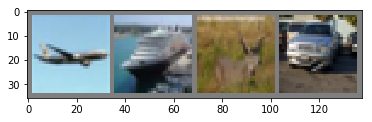

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 显示图片的函数


def imshow(img):
    img = img / 2 + 0.5     #  [-1,1] -> [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (channel, width, height) -> (width, height, channel)


# 随机选择一些图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印label
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # 这里只迭代2个epoch，实际应该进行更多次训练 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 得到输入
        inputs, labels = data

        # 梯度清零 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 定义统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.251
[1,  4000] loss: 1.901
[1,  6000] loss: 1.695
[1,  8000] loss: 1.613
[1, 10000] loss: 1.519
[1, 12000] loss: 1.475
[2,  2000] loss: 1.415
[2,  4000] loss: 1.405
[2,  6000] loss: 1.364
[2,  8000] loss: 1.346
[2, 10000] loss: 1.313
[2, 12000] loss: 1.288
Finished Training


GroundTruth:    cat  ship  ship plane


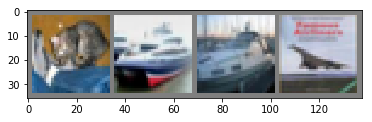

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

现在我们用模型来预测这些样本：



In [9]:
outputs = net(images)

outputs是10个分类的logits。我们在训练的时候需要用softmax把它变成概率(CrossEntropyLoss帮我们做了)，但是预测的时候没有必要，因为我们只需要知道哪个分类的概率大就行。


In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


结果还不错。接下来我们看看在整个测试集合上的效果：


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


看起来比随机的瞎猜要好，因为随机猜的准确率大概是10%的准确率。因此模型确实学到了一些。我们也可以看每个分类的准确率：




In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 58 %
Accuracy of  bird : 46 %
Accuracy of   cat : 44 %
Accuracy of  deer : 42 %
Accuracy of   dog : 48 %
Accuracy of  frog : 58 %
Accuracy of horse : 48 %
Accuracy of  ship : 76 %
Accuracy of truck : 53 %



在GPU上训练
----------------
为了在GPU上训练，我们需要把Tensor移到GPU上。首先我们看看是否有gpu，如果没有，那么我们还是fallback到cpu。



In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 

print(device)

cuda:0


用GPU进行训练

In [16]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5).to(device)
        self.pool = nn.MaxPool2d(2, 2).to(device)
        self.conv2 = nn.Conv2d(6, 16, 5).to(device)
        self.fc1 = nn.Linear(16 * 5 * 5, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, 10).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 得到输入
        inputs, labels = data 
        inputs, labels = inputs.to(device), labels.to(device) 
        # 梯度清零 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 定义统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.189
[1,  4000] loss: 1.842
[1,  6000] loss: 1.684
[1,  8000] loss: 1.597
[1, 10000] loss: 1.515
[1, 12000] loss: 1.475
[2,  2000] loss: 1.407
[2,  4000] loss: 1.385
[2,  6000] loss: 1.358
[2,  8000] loss: 1.334
[2, 10000] loss: 1.332
[2, 12000] loss: 1.282
[3,  2000] loss: 1.237
[3,  4000] loss: 1.227
[3,  6000] loss: 1.229
[3,  8000] loss: 1.215
[3, 10000] loss: 1.211
[3, 12000] loss: 1.177
[4,  2000] loss: 1.138
[4,  4000] loss: 1.100
[4,  6000] loss: 1.144
[4,  8000] loss: 1.136
[4, 10000] loss: 1.112
[4, 12000] loss: 1.104
[5,  2000] loss: 1.045
[5,  4000] loss: 1.066
[5,  6000] loss: 1.060
[5,  8000] loss: 1.060
[5, 10000] loss: 1.042
[5, 12000] loss: 1.064
[6,  2000] loss: 0.977
[6,  4000] loss: 0.990
[6,  6000] loss: 0.990
[6,  8000] loss: 1.003
[6, 10000] loss: 1.031
[6, 12000] loss: 1.032
[7,  2000] loss: 0.908
[7,  4000] loss: 0.928
[7,  6000] loss: 0.956
[7,  8000] loss: 0.964
[7, 10000] loss: 0.973
[7, 12000] loss: 0.996
[8,  2000] loss: 0.867
[8,  4000] 

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %
